The architecture is::

conv1-->relu-->conv2-->relu-->conv3-->relu-->pool-->

conv4-->relu-->conv5-->relu-->conv6-->relu-->pool-->

conv7-->relu-->conv8-->relu-->conv9-->relu-->pool-->

fully_connected_1-->relu-->fully_connected_2-->relu-->fully_connected_3 **[OUTPUT]**

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader= torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes=('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # 11 Layers : 8 conv layers and 3 fully connected layers !
        self.conv1 = nn.Conv2d(3, 8, 3,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 12, 3,padding=1)
        self.conv2_bn = nn.BatchNorm2d(12)
        self.conv3 = nn.Conv2d(12,20, 3,padding=1)
        self.conv3_bn = nn.BatchNorm2d(20)
        self.conv4 = nn.Conv2d(20,24, 3,padding=1)
        self.conv4_bn = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(24,32, 3,padding=1)
        self.conv5_bn = nn.BatchNorm2d(32)
        self.conv6 = nn.Conv2d(32,48, 3,padding=1)
        self.conv6_bn = nn.BatchNorm2d(48)
        self.conv7 = nn.Conv2d(48,64, 3,padding=1)
        self.conv7_bn = nn.BatchNorm2d(64)
        self.conv8 = nn.Conv2d(64,72, 3,padding=1)
        self.conv8_bn = nn.BatchNorm2d(72)
        self.conv9 = nn.Conv2d(72,80, 3,padding=1)
        self.conv9_bn = nn.BatchNorm2d(80)
        self.fc1 = nn.Linear(80*4*4, 120)
        self.fc1_bn = nn.BatchNorm2d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc2_bn = nn.BatchNorm2d(84)
        self.fc3 = nn.Linear(84, 10)

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2_bn((self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn((self.conv3(x)))))
        x = F.relu(self.conv4_bn((self.conv4(x))))
        x = F.relu(self.conv5_bn((self.conv5(x))))
        x = self.pool(F.relu(self.conv6_bn((self.conv6(x)))))
        x = F.relu(self.conv7_bn((self.conv7(x))))
        x = F.relu(self.conv8_bn((self.conv8(x))))
        x = self.pool(F.relu(self.conv9_bn((self.conv9(x)))))

        x = x.view(-1, 80*4*4)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc3(x)
        return x

In [7]:
# Function to create an instance of the model on CUDA
loss_list = []
def new_net(lrate,wd):
    global loss_list
    net = Net().cuda()

    # net=Net()

    lossvsiter=[]

    # To see if the model is on CUDA or not !
    if (next(net.parameters()).is_cuda) :
        print("The model is on CUDA")
    else :
        print("The model is on CPU")

    # Import the optimizers 
    import torch.optim as optim

    # Declare a loss function
    criterion = nn.CrossEntropyLoss()

    # Declare an optimizer
    optimizer = optim.Adam(net.parameters(),lr=lrate,weight_decay=wd)

    #No of iterations !
    iterations = 25
    


    for epoch in range(iterations):  # loop over the dataset multiple times

        # Reset the loss for the current epoch !
        tloss = 0
        running_loss = 0.0

        # Loop over all the mini-batches therea are 12500 mini batches of size 4 each !
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable & if possible make them cuda tensors
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            # zero the parameter gradients for the current epoch
            optimizer.zero_grad()

            # forward + backward + optimize

            # forward
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # Calculate gradients of whatever variable set to req_gardients = True
            loss.backward()

            # Take one step of the gradient descent for this epoch ! 
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
            tloss += loss.data[0]
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[Epoch :: %d, Mini Batch :: %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                lossvsiter.append(running_loss / 2000)
                running_loss = 0.0
        loss_list.append(tloss)

    print('Finished Training')
    return lossvsiter,net

In [8]:
learnin_rate_sample=[0.0005,0.0007,0.001,0.0001,]
weight_decay_smaple=[1e-6,1e-7,1e-5,1e-4,1e-3,1e-2]

In [ ]:
lossvsiter_crazy_architecture_with_batch_norm,model_crazy_architecture_with_batch_norm=new_net(0.0005,1e-7)

The model is on CUDA
[Epoch :: 1, Mini Batch ::  2000] loss: 2.024
[Epoch :: 1, Mini Batch ::  4000] loss: 1.861
[Epoch :: 1, Mini Batch ::  6000] loss: 1.735
[Epoch :: 1, Mini Batch ::  8000] loss: 1.628
[Epoch :: 1, Mini Batch :: 10000] loss: 1.568
[Epoch :: 1, Mini Batch :: 12000] loss: 1.512
[Epoch :: 2, Mini Batch ::  2000] loss: 1.438
[Epoch :: 2, Mini Batch ::  4000] loss: 1.411
[Epoch :: 2, Mini Batch ::  6000] loss: 1.369
[Epoch :: 2, Mini Batch ::  8000] loss: 1.340
[Epoch :: 2, Mini Batch :: 10000] loss: 1.298
[Epoch :: 2, Mini Batch :: 12000] loss: 1.257
[Epoch :: 3, Mini Batch ::  2000] loss: 1.232
[Epoch :: 3, Mini Batch ::  4000] loss: 1.226
[Epoch :: 3, Mini Batch ::  6000] loss: 1.204
[Epoch :: 3, Mini Batch ::  8000] loss: 1.167
[Epoch :: 3, Mini Batch :: 10000] loss: 1.143
[Epoch :: 3, Mini Batch :: 12000] loss: 1.140
[Epoch :: 4, Mini Batch ::  2000] loss: 1.096
[Epoch :: 4, Mini Batch ::  4000] loss: 1.103
[Epoch :: 4, Mini Batch ::  6000] loss: 1.071
[Epoch :: 4, 

59


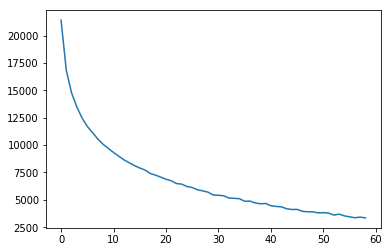

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_list)
print(len(loss_list))

In [17]:
def new_net2(lrate,wd,prenet):
    global loss_list
    net = prenet

    # net=Net()

    lossvsiter=[]

    # To see if the model is on CUDA or not !
    if (next(net.parameters()).is_cuda) :
        print("The model is on CUDA")
    else :
        print("The model is on CPU")

    # Import the optimizers 
    import torch.optim as optim

    # Declare a loss function
    criterion = nn.CrossEntropyLoss()

    # Declare an optimizer
    optimizer = optim.Adam(net.parameters(),lr=lrate,weight_decay=wd)

    #No of iterations !
    iterations = 25
    


    for epoch in range(iterations):  # loop over the dataset multiple times

        # Reset the loss for the current epoch !
        tloss = 0
        running_loss = 0.0

        # Loop over all the mini-batches therea are 12500 mini batches of size 4 each !
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable & if possible make them cuda tensors
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            # zero the parameter gradients for the current epoch
            optimizer.zero_grad()

            # forward + backward + optimize

            # forward
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # Calculate gradients of whatever variable set to req_gardients = True
            loss.backward()

            # Take one step of the gradient descent for this epoch ! 
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
            tloss += loss.data[0]
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[Epoch :: %d, Mini Batch :: %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                lossvsiter.append(running_loss / 2000)
                running_loss = 0.0
        loss_list.append(tloss)

    print('Finished Training')
    return lossvsiter,net

In [20]:
lossvsiter_crazy_architecture_with_batch_norm,model_crazy_architecture_with_batch_norm=new_net2(0.0005,1e-7,model_crazy_architecture_with_batch_norm)

The model is on CUDA
[Epoch :: 1, Mini Batch ::  2000] loss: 0.285
[Epoch :: 1, Mini Batch ::  4000] loss: 0.298
[Epoch :: 1, Mini Batch ::  6000] loss: 0.300
[Epoch :: 1, Mini Batch ::  8000] loss: 0.307
[Epoch :: 1, Mini Batch :: 10000] loss: 0.322
[Epoch :: 1, Mini Batch :: 12000] loss: 0.317
[Epoch :: 2, Mini Batch ::  2000] loss: 0.284
[Epoch :: 2, Mini Batch ::  4000] loss: 0.310
[Epoch :: 2, Mini Batch ::  6000] loss: 0.307
[Epoch :: 2, Mini Batch ::  8000] loss: 0.296
[Epoch :: 2, Mini Batch :: 10000] loss: 0.299
[Epoch :: 2, Mini Batch :: 12000] loss: 0.324
[Epoch :: 3, Mini Batch ::  2000] loss: 0.283
[Epoch :: 3, Mini Batch ::  4000] loss: 0.299
[Epoch :: 3, Mini Batch ::  6000] loss: 0.279
[Epoch :: 3, Mini Batch ::  8000] loss: 0.288
[Epoch :: 3, Mini Batch :: 10000] loss: 0.279
[Epoch :: 3, Mini Batch :: 12000] loss: 0.293
[Epoch :: 4, Mini Batch ::  2000] loss: 0.273
[Epoch :: 4, Mini Batch ::  4000] loss: 0.304
[Epoch :: 4, Mini Batch ::  6000] loss: 0.302
[Epoch :: 4, 

Process Process-124:
Process Process-123:
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/siplab/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/local/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/local/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

  File "/home/siplab/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/local/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/local/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/local/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/local/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [22]:
def test_accuracy(model):
    correct = 0
    total = 0

    for data in testloader:
        images, labels = data
        images=images.cuda()
        labels=labels.cuda()
        try:
            outputs = model(Variable(images))
        except RuntimeError as re:
            print(outputs.is_cuda)
            print(str(re))
            sys.exit()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        accuracy_percentage= 100 * correct / total

    print('Accuracy of the network on the 10000 test images: %d' % (accuracy_percentage))
    print("The network predicted correct for %s"%(correct))
    return accuracy_percentage,correct

test_accuracy(model_crazy_architecture_with_batch_norm)

Accuracy of the network on the 10000 test images: 77
The network predicted correct for 7748


(77.48, 7748)

In [12]:
def train_accuracy(model):
    net = model
    total=0
    correct=0
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        images=images.cuda()
        labels=labels.cuda()
        try:
            outputs = net(Variable(images))
        except RuntimeError as re:
            print(outputs.is_cuda)
            print(str(re))
            sys.exit()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        if (i%1000) == 0:
            print(i)

    print('Accuracy of the network on the 50000 trained images: %d %%' % (
        100 * correct / total))

In [12]:
test_accuracy(model_crazy_architecture_with_batch_norm)

Accuracy of the network on the 10000 test images: 76
The network predicted correct for 7606


(76.06, 7606)

In [14]:
train_accuracy(model_crazy_architecture_with_batch_norm)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
Accuracy of the network on the 50000 trained images: 84 %


In [22]:
# It seems the loss will further decrease with more iterations !